## Steps to create a world class Image Classifier 


1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

##  The Planet Challenge

### 1.  Load the fastAI library and do the initial setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = f'data/planets/'
os.makedirs(PATH+'models', exist_ok = True)

In [6]:
!ls -l {PATH}

total 3184244
drwxrwxr-x 2 arifwork176 arifwork176      4096 Feb 28 18:57 __MACOSX
drwxrwxr-x 2 arifwork176 arifwork176      4096 Feb 28 19:00 models
-rw-r--r-- 1 arifwork176 arifwork176   2914964 May  9  2017 sample_submission_v2.csv
-rw-rw-r-- 1 arifwork176 arifwork176    157221 Feb 28 18:36 sample_submission_v2.csv.zip
drwxrwxr-x 2 arifwork176 arifwork176   2080768 May  4  2017 test-jpg
drwxrwxr-x 2 arifwork176 arifwork176    688128 May  4  2017 test-jpg-additional
-rw-rw-r-- 1 arifwork176 arifwork176 336865280 May  6  2017 test-jpg-additional.tar
-rw-rw-r-- 1 arifwork176 arifwork176 318407195 Feb 28 18:36 test-jpg-additional.tar.7z
-rw-rw-r-- 1 arifwork176 arifwork176 668989440 Apr 19  2017 test-jpg.tar
-rw-rw-r-- 1 arifwork176 arifwork176 632362315 Feb 28 18:25 test-jpg.tar.7z
-rw-rw-r-- 1 arifwork176 arifwork176    112887 Feb 28 18:36 test_v2_file_mapping.csv.zip
drwxrwxr-x 5 arifwork176 arifwork176      4096 Feb 28 19:26 tmp
drwxrwxr-x 2 arifwork176 arifwork176   1380352 Apr 19 

### 2. Looking at couple of Images 

In [7]:
from fastai.plots import *

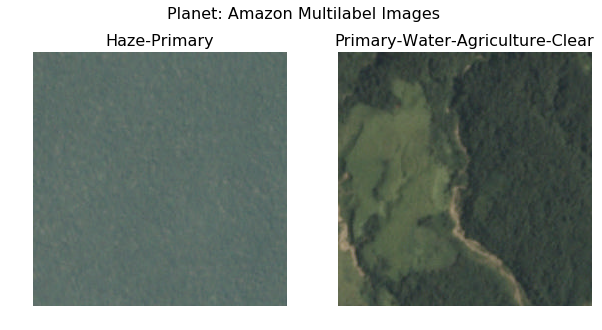

In [8]:
path_list = [f'{PATH}train-jpg/train_0.jpg', f'{PATH}train-jpg/train_1.jpg']
titles = ['Haze-Primary', 'Primary-Water-Agriculture-Clear']
plots_from_files(imspaths= path_list, titles=titles, maintitle= 'Planet: Amazon Multilabel Images')

### 3. Multi-label models for Planet Images - Initial Exploration

In [8]:
# 1. Metrics as directed by Kaggle
from planet import *
metrics = [f2]
arch = resnet50

In [9]:
# 2. Get the Validation indexes 
label_csv = f'{PATH}train_v2.csv'
n= len(list(open(label_csv)))-1
print(n)
val_idxs = get_cv_idxs(n)
print('Validation sample-size: {}'.format(len(val_idxs)))

40479
Validation sample-size: 8095


In [10]:
# 3. Create the get_data function
def get_data(sz, bs):
    tfms = tfms_from_model(f_model=arch, sz=sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', csv_fname= label_csv, bs=bs, tfms=tfms, 
                                       val_idxs=val_idxs, suffix='.jpg',test_name= 'test-jpg')

In [11]:
data = get_data(256, 32)

In [13]:
x, y = next(iter(data.val_dl))

In [14]:
y.size() #its 32 because bs=32, complete iterator size is ([8095, 17])

torch.Size([32, 17])

In [15]:
# 4. Take a look a multilabel sample
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

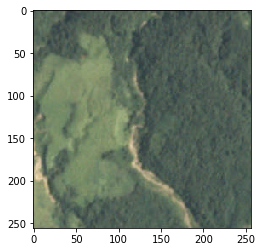

In [43]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4) #Multiplying the image by 1.4 makes is slightly brighter

### 4. We can start to train our models from here 
This competition is not like the ImageNet challenge, so we will have to sort of more liberally retrain by unfreezing the layers 

#### 4.1 We will start with small images - `sz=64`

In [11]:
# Get data with size=64
sz=64
data = get_data(64, 64)

In [12]:
# This step is not necessarily needed. It just makes things faster for larger images that go into the system
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [17]:
# Create the Learn object
learn = ConvLearner.pretrained(arch, data, metrics=metrics)

In [18]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 99%|█████████▊| 997/1012 [02:00<00:01,  8.30it/s, loss=0.644]

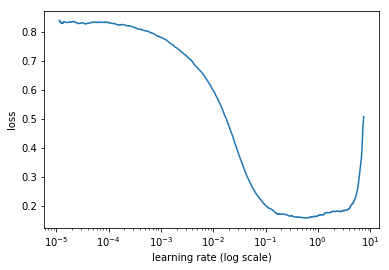

In [19]:
learn.sched.plot()

In [20]:
# Fit using frozen layers 
lr = 0.2

In [23]:
%time learn.fit(lr,3,cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  6%|▋         | 64/1012 [00:07<01:53,  8.37it/s, loss=0.666]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/arifwork176/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/arifwork176/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/arifwork176/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   f2                            
    0      0.123217   0.111217   0.906781  
    1      0.117393   0.107284   0.909625                      
    2      0.110611   0.104909   0.912184                      
    3      0.118054   0.105732   0.910604                      
    4      0.111241   0.103529   0.912595                      
    5      0.110702   0.101474   0.915673                      
    6      0.107321   0.10184    0.915271                      

CPU times: user 39min 46s, sys: 4min 47s, total: 44min 33s
Wall time: 14min 45s


[0.10184035, 0.9152712494807144]

In [19]:
# Now lets train with differntial learning rates
lrs= [lr/9, lr/3, lr]
learn.unfreeze()

In [20]:
%time learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.11863    0.107491   0.910593  
    1      0.113848   0.103114   0.914572                    
    2      0.103186   0.099612   0.916805                    
    3      0.108376   0.103789   0.911819                    
    4      0.103359   0.098939   0.916187                    
    5      0.099363   0.096737   0.918813                     
    6      0.095813   0.096762   0.919426                     

CPU times: user 7min 48s, sys: 2min 33s, total: 10min 22s
Wall time: 6min 37s


[0.09676243, 0.9194259400519038]

In [21]:
learn.save(f'resnet50_64') # Saved inside {PATH}/tmp/83/

In [28]:
learn.load(f'resnet50_64')

#### 4.2. Time to increase the image size to `sz=128`

In [22]:
# Get data with the 128x128 spatial size
data = get_data(128,32)
sz=128
#data = data.resize(int(sz*1.3),'tmp')

In [23]:
# Configure your learn object with the newest data size
learn.set_data(data)
# You don't want to re-train the initial layers no more 
learn.unfreeze()
%time learn.fit(lrs, 3, cycle_len = 1, cycle_mult= 2)


HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                             
    0      0.096483   0.087523   0.929975  
    1      0.095365   0.089319   0.926466                       
    2      0.087942   0.086038   0.93017                        
    3      0.098347   0.09062    0.926623                       
    4      0.087696   0.088438   0.927838                       
    5      0.08885    0.085631   0.930354                       
    6      0.082637   0.084498   0.930694                       

CPU times: user 24min 21s, sys: 3min 48s, total: 28min 9s
Wall time: 12min 41s


[0.084498465, 0.9306935672376331]

In [24]:
learn.save(f'resnet50_128')

In [25]:
learn.load(f'resnet50_128')

#### 4.3 Increasing the image size further to `sz=256`

In [77]:
# Get data with the 256x256 spatial size
data = get_data(256,32)
sz=256
#data = data.resize(int(sz*1.3),'tmp')

In [26]:
# Configure your learn object with the newest data size
learn.set_data(data)

In [27]:
# You don't want to re-train the initial layers no more 
learn.freeze()
%time learn.fit(lr, 3, cycle_len = 1, cycle_mult= 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                             
    0      0.086083   0.08865    0.927084  
    1      0.090713   0.088071   0.926962                       
    2      0.090692   0.087997   0.927153                       
    3      0.089277   0.088833   0.925263                       
    4      0.086791   0.087662   0.926625                       
    5      0.085364   0.087348   0.927214                       
    6      0.087433   0.08662    0.928149                       

CPU times: user 39min 58s, sys: 4min 53s, total: 44min 51s
Wall time: 14min 45s


[0.08662033, 0.9281493476008522]

In [28]:
# Slightly underfitted, can run a couple of more epochs 
learn.unfreeze()
%time learn.fit(lr, 1, cycle_len = 1, cycle_mult= 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                             
    0      0.092566   0.085435   0.931455  

CPU times: user 7min 22s, sys: 1min 27s, total: 8min 49s
Wall time: 4min 34s


[0.08543493, 0.9314554630692552]

In [15]:
learn.save(f'resnet50_256')
#learn.save(f'test')

In [27]:
learn.load(f'resnet50_256')

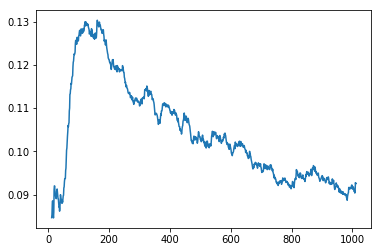

In [32]:
learn.sched.plot_loss()

### 5. Making a submission 

In [30]:
# Prediction on the test-data with TTA
%time tta = learn.TTA(is_test=True)

CPU times: user 41min 15s, sys: 3min 54s, total: 45min 9s
Wall time: 12min 1s


In [31]:
# Create the right format for sumbission
test_fnames = data.test_ds.fnames; test_fnames[:5]

['test-jpg/test_18542.jpg',
 'test-jpg/file_9809.jpg',
 'test-jpg/file_9141.jpg',
 'test-jpg/test_25492.jpg',
 'test-jpg/test_29822.jpg']

In [32]:
test_names = [i.split('/')[1].split('.')[0] for i in test_fnames]; test_names[:5]

['test_18542', 'file_9809', 'file_9141', 'test_25492', 'test_29822']

In [33]:
# get the classes
classes = np.array(data.classes, dtype=str); classes[:4]

array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming'], dtype='<U17')

In [34]:
np.shape(tta[0][0])

(61191, 17)

In [37]:
res = [" ".join(classes[np.where(pp > 0.2)]) for pp in tta[0][0]]; res[:5]

['agriculture clear habitation primary road',
 'cloudy',
 'agriculture partly_cloudy primary',
 'clear primary',
 'agriculture clear haze primary road water']

In [41]:
submission = pd.DataFrame(res)
submission.columns = ["tags"]

In [43]:
submission.insert(0, "image_name", test_names)

In [44]:
submission.head()

,image_name,tags
0,test_18542,agriculture clear habitation primary road
1,file_9809,cloudy
2,file_9141,agriculture partly_cloudy primary
3,test_25492,clear primary
4,test_29822,agriculture clear haze primary road water


In [45]:
submission.to_csv(PATH+"Submit_0103.csv", index=False)

In [46]:
FileLink(f'{PATH}Submit_0103.csv')

/home/arifwork176/fastai/courses/dl1/data/planets/Submit_0103.csv

Kaggle Private Score of 92.802. Not too bad considering you are not using complete set for training

## Whale Identification Challenge

### 1. Load FastAI library and initial setup

In [1]:
# matplotlib initialization
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import learner
from fastai.conv_learner import *

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = f'data/whale/'

In [6]:
! ls -l {PATH}

total 683036
drwxrwxr-x 2 arifwork176 arifwork176      4096 Mar  2 08:40 models
-rw-rw-r-- 1 arifwork176 arifwork176    983439 Mar  2 06:19 sample_submission.csv
drwxrwxr-x 2 arifwork176 arifwork176    503808 Jul 27  2017 test
-rw-rw-r-- 1 arifwork176 arifwork176 424989603 Mar  2 06:19 test.zip
drwxrwxr-x 2 arifwork176 arifwork176      4096 Mar  2 08:40 tmp
drwxrwxr-x 2 arifwork176 arifwork176    266240 Jul 27  2017 train
-rw-rw-r-- 1 arifwork176 arifwork176    226559 Mar  2 06:19 train.csv
-rw-rw-r-- 1 arifwork176 arifwork176 272433790 Mar  2 06:20 train.zip


### 2. Looking at couple of images

In [7]:
from fastai.plots import *
import random 
import os

In [8]:
image_list = os.listdir(PATH+'train/')

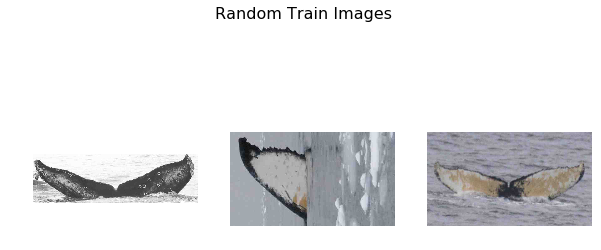

In [9]:
plots_from_files([PATH+'test/'+i for i in random.choices(os.listdir(PATH+'test/'), k=3)],
                 maintitle='Random Train Images')

### 3. Initial Exploration 

In [10]:
# 1. Get the  validation_idx
label_csv = f'{PATH}train.csv'

n = len(list(open(label_csv)))-1
print(n)
val_idxs = get_cv_idxs(n)
print(val_idxs[:5])

9850
[8920 9839 1851 6334 8516]


In [11]:
# 2. get_data function
f_model = resnet50
def get_data(sz):
    tfms = tfms_from_model(f_model, sz=sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                                        test_name='test', val_idxs= val_idxs)


In [12]:
data = get_data(256)
x, y = next(iter(data.val_dl))

In [13]:
print(x.size())
print(y.size())

torch.Size([64, 3, 256, 256])
torch.Size([64])


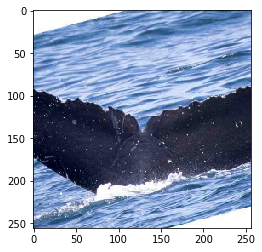

In [14]:
plt.imshow(data.val_ds.denorm(to_np(x))[2]) # You need to denorm x in order to be able to imshow the image

#### 4. We can start to train our models from here

#### 4.1 Lets start with smaller image sizes `(sz=64)`

In [17]:
# Smaller image sizes
data = get_data(64)

In [18]:
learn = ConvLearner.pretrained(f_model, data)

In [94]:
# Find learning rate
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 113/124 [00:30<00:02,  3.76it/s, loss=43.5]

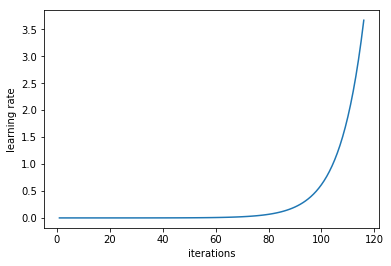

In [96]:
learn.sched.plot_lr()

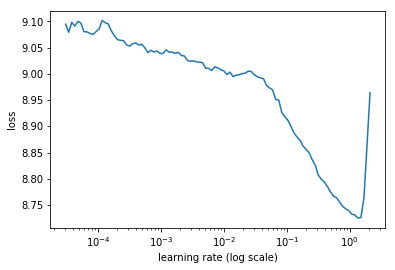

In [97]:
learn.sched.plot()

In [19]:
# set learning rate 
lr=0.5
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCTensorCopy.c:70

In [ ]:
img_rgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)